In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import pydicom
from skimage.io import imread
from tabulate import tabulate

from model import *
from other_models import *

sys.path.append("../")
from metrics import *
sys.path.append("../../")
from preprocess_helpers import *

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load Trained Model

In [2]:
model = unet_2d_res()
model.load_weights('best_proposed.hdf5')

og_unet = unet()
og_unet.load_weights('best_unet_og.hdf5')

og_resunet = original_resunet()
og_resunet.load_weights('best_resunet.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Load Data

In [3]:
X_train = np.array([
    imread(f'data/train/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/train/image/')
])
y_train = np.array([
    imread(f'data/train/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/train/label/')
])
print(X_train.shape)
print(y_train.shape)

X_test = np.array([
    imread(f'data/test/image/{im}').reshape(256, 256, 1)/255
    for im in os.listdir('data/test/image/')
])
y_test = np.array([
    imread(f'data/test/label/{im}').reshape(256, 256, 1)
    for im in os.listdir('data/test/label/')
])


print(X_test.shape)
print(y_test.shape)

(5013, 256, 256, 1)
(5013, 256, 256, 1)
(138, 256, 256, 1)
(138, 256, 256, 1)


# Predict

In [4]:
def printing_helper(X, y_true, mod, prefix="", plot=False):
    y_hat = mod.predict(X)
    y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(12, 20))
        axs[0].imshow(X.reshape(256, 256), cmap='bone')
        axs[1].imshow(y_true.reshape(256, 256), cmap='bone')
        axs[2].imshow(y_hat.reshape(256, 256), cmap='bone')
        axs[3].imshow(y_hat_post.reshape(256, 256), cmap='bone')
        
        axs[0].set_title("Input")
        axs[1].set_title("True Mask")
        axs[2].set_title("Predicted Mask\n (Before Post-Processing)")
        axs[3].set_title("Predicted Mask\n (After Post-Processing)")
        plt.show()
    
    print(tabulate([
        ['Recall', image_recall(y_true, y_hat[0]), image_recall(y_true, y_hat_post)],
        ['Precision', image_precision(y_true, y_hat[0]), image_precision(y_true, y_hat_post)],
        ['Dice', dice_coef(y_true, y_hat[0]), dice_coef(y_true, y_hat_post)],
    ],headers=['', 'Before Post-Processing', 'After Post-Processing']))
    
    print(f"\n{prefix} Percent included in ROI {percent_included(y_true, y_hat[0])}")

### Train example

560
Proposed Model


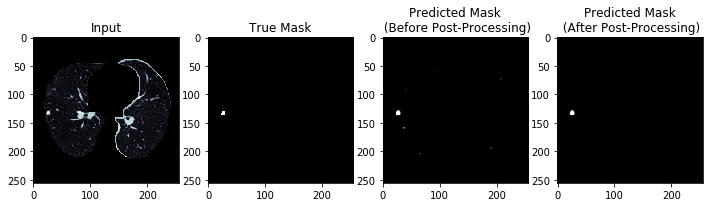

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     1                        1
Precision                  0.693548                 0.741379
Dice                       0.820755                 0.852941

 Percent included in ROI 1.0

Original ResUnet


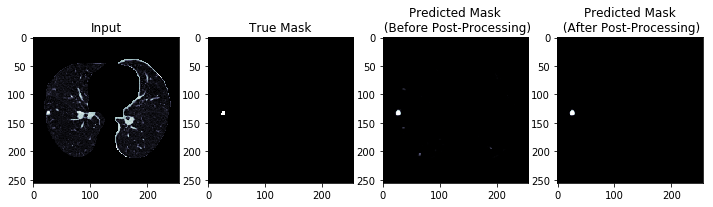

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     1                        1
Precision                  0.641791                 0.641791
Dice                       0.783784                 0.783784

 Percent included in ROI 1.0

Original U-Net


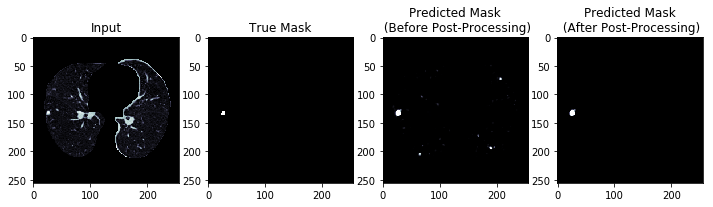

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                      1                       1
Precision                   0.40566                 0.558442
Dice                        0.58                    0.719008

 Percent included in ROI 1.0


In [5]:
idx = np.random.randint(len(os.listdir('data/train/image')))
print(idx)

print("Proposed Model")
printing_helper(X_train[[idx]], y_train[idx], model, plot=True)
print("\nOriginal ResUnet")
printing_helper(X_train[[idx]], y_train[idx], og_resunet, plot=True)
print("\nOriginal U-Net")
printing_helper(X_train[[idx]], y_train[idx], og_unet, plot=True)

### Test example

89
Proposed Model


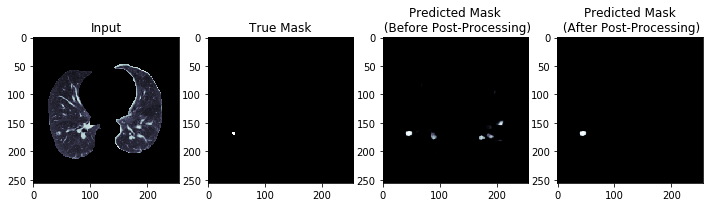

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     1                        1
Precision                  0.127273                 0.388889
Dice                       0.228916                 0.564356

 Percent included in ROI 1.0

Original ResUnet


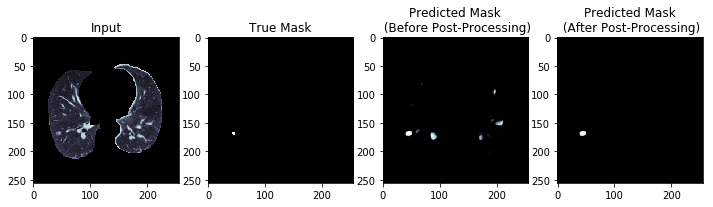

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     1                        1
Precision                  0.102941                 0.368421
Dice                       0.189369                 0.542857

 Percent included in ROI 1.0

Original U-Net


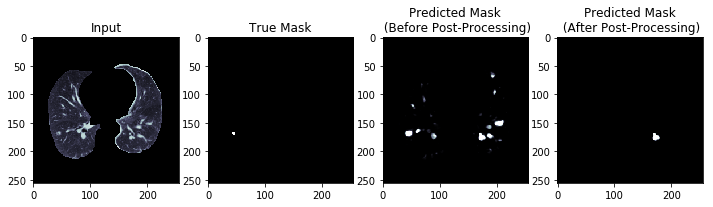

             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                    1                       0
Precision                 0.0630631               0
Dice                      0.120507                0.00813008

 Percent included in ROI 0.0


In [6]:
idx = np.random.randint(len(os.listdir('data/test/image')))
print(idx)

print("Proposed Model")
printing_helper(X_test[[idx]], y_test[idx], model, plot=True)
print("\nOriginal ResUnet")
printing_helper(X_test[[idx]], y_test[idx], og_resunet, plot=True)
print("\nOriginal U-Net")
printing_helper(X_test[[idx]], y_test[idx], og_unet, plot=True)

### Train Overall

In [8]:
train_recall = []
train_precision = []
train_dice = []
train_dice_post = []
train_percent_included = []

for i in range(len(X_train)):
    sys.stdout.write(f'\r{i}')
    y_hat = model.predict(X_train[[i]])
    y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)
    train_recall.append(image_recall(y_train[i], y_hat[0]))
    train_precision.append(image_precision(y_train[i], y_hat[0]))
    train_dice.append(dice_coef(y_train[i], y_hat[0]))
    train_dice_post.append(dice_coef(y_train[i], y_hat_post))
    train_percent_included.append(percent_included(y_train[i], y_hat[0]))

train_recall = np.array(train_recall)
train_precision = np.array(train_precision)
train_precision = train_precision[np.logical_not(np.isnan(train_precision))]
train_dice = np.array(train_dice)
train_dice_post = np.array(train_dice_post)
train_percent_included = np.array(train_percent_included)

print()
print(np.array(f"Training set average recall: {train_recall.mean()}"))
print(np.array(f"Training set average precision: {train_precision.mean()}"))
print(np.array(f"Training set average dice coefficient: {train_dice.mean()}"))
print(np.array(f"Training set dice coefficient (post): {train_dice_post.mean()}"))
print(np.array(f"Training set average percent included in ROI: {train_percent_included.mean()}"))


Training set average recall: 0.7594921588897705
Training set average precision: 0.5767268538475037
Training set average dice coefficient: 0.627840110235001
Training set dice coefficient (post): 0.6223093023165209
Training set average percent included in ROI: 0.8333333333333334


### Test Overall

In [11]:
for name, mod in [
    ("Proposed Model", model), ("Original ResUnet", og_resunet), ("Original U-Net", og_unet)
]:
    test_recall_pre = []
    test_recall_post = []
    test_precision_pre = []
    test_precision_post = []
    test_dice_pre = []
    test_dice_post = []
    test_percent_included = []

    for i in range(len(X_test)):
        sys.stdout.write(f'\r{i}')
        y_hat = mod.predict(X_test[[i]])
        y_hat_post = get_most_activated_roi_mask(y_hat[0]).reshape(256, 256, 1)
        test_recall_pre.append(image_recall(y_test[i], y_hat[0]))
        test_recall_post.append(image_recall(y_test[i], y_hat_post))
        test_precision_pre.append(image_precision(y_test[i], y_hat[0]))
        test_precision_post.append(image_precision(y_test[i], y_hat_post))
        test_dice_pre.append(dice_coef(y_test[i], y_hat[0]))
        test_dice_post.append(dice_coef(y_test[i], y_hat_post))
        test_percent_included.append(percent_included(y_test[i], y_hat[0]))


    test_recall_pre = np.array(test_recall_pre)
    test_recall_post = np.array(test_recall_post)
    test_precision_pre = np.array(test_precision_pre)
    test_precision_pre = test_precision_pre[np.logical_not(np.isnan(test_precision_pre))]
    test_precision_post = np.array(test_precision_post)
    test_precision_post = test_precision_post[np.logical_not(np.isnan(test_precision_post))]
    test_dice_pre = np.array(test_dice_pre)
    test_dice_post = np.array(test_dice_post)
    test_percent_included = np.array(test_percent_included)

    print(f"\n{name}")
    print(tabulate([
        ['Recall', test_recall_pre.mean(), test_recall_post.mean()],
        ['Precision', test_precision_pre.mean(), test_precision_post.mean()],
        ['Dice', test_dice_pre.mean(), test_dice_post.mean()]
    ],headers=['', 'Before Post-Processing', 'After Post-Processing']))

137
Proposed Model
             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     0.805924                 0.779171
Precision                  0.643758                 0.689438
Dice                       0.676842                 0.702624
137
Original ResUnet
             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     0.762378                 0.730502
Precision                  0.660449                 0.679234
Dice                       0.641784                 0.643943
137
Original U-Net
             Before Post-Processing    After Post-Processing
---------  ------------------------  -----------------------
Recall                     0.917093                 0.755113
Precision                  0.38268                  0.447454
Dice                       0.509177                 0.543451
